# Multi-Class Classification with Transformer Encoder

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchinfo
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPU 2 to use
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device2 = T.device("cuda:1" if T.cuda.is_available() else "cpu")
# device = T.device("cpu")
from encoding.parallel import DataParallelModel, DataParallelCriterion

from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
metric_collection = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="none").to(device),
    MulticlassPrecision(num_classes=4, average="none").to(device),
    MulticlassRecall(num_classes=4, average="none").to(device),
    MulticlassF1Score(num_classes=4, average="none").to(device),
])
metric_collection_weighted = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="weighted").to(device),
    MulticlassPrecision(num_classes=4, average="weighted").to(device),
    MulticlassRecall(num_classes=4, average="weighted").to(device),
    MulticlassF1Score(num_classes=4, average="weighted").to(device),
])
import sklearn.datasets
import umap
import umap.plot
# /home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py 에 @numba.jit(nopython=True) 추가
import shap
import scipy as sp
# import transformers
print("Pytorch version:", T.__version__, "cuDNN version:", T.backends.cudnn.version(), "CUDA version:", T.version.cuda) 
device, T.cuda.get_device_name(0)

Pytorch version: 1.12.1 cuDNN version: 8302 CUDA version: 11.3


/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


(device(type='cuda'), 'NVIDIA RTX A6000')

## 2. Implementing the Backbone of Transformer-based Classifier

In [119]:
hf = h5py.File('STAD_Dataset2_Train.h5', 'r')
print(hf.keys())

X_Train_for_SHAP = np.array(hf.get('X_Train'))
X_Train = np.array(hf.get('X_Train')).astype('int64')
Y_Train = np.array(hf.get('Y_Train')).astype('int8')
print('X_Train.shape : ', X_Train.shape)
print('Y_Train.shape : ', Y_Train.shape)

hf.close()
print('X_Train_for_SHAP.shape : ', X_Train_for_SHAP.shape)
print("dtype of X_Train_for_SHAP=", X_Train_for_SHAP.dtype )
X_Train.dtype, Y_Train.dtype

<KeysViewHDF5 ['X_Train', 'Y_Train']>
X_Train.shape :  (325, 1157)
Y_Train.shape :  (325,)
X_Train_for_SHAP.shape :  (325, 1157)
dtype of X_Train_for_SHAP= float64


(dtype('int64'), dtype('int8'))

In [120]:
X_Train_SHAP_zero_replaced = np.zeros(X_Train_for_SHAP.shape)
hepsilon = 0.1
for i in range(X_Train_for_SHAP.shape[0]):
    for j, x in enumerate(X_Train_for_SHAP[i]):
        if x == 0 :
            X_Train_SHAP_zero_replaced[i][j] = hepsilon
            hepsilon += 0.00005
        else : 
            X_Train_SHAP_zero_replaced[i][j] = X_Train_for_SHAP[i][j]
X_Train_SHAP_zero_replaced.shape

(325, 1157)

In [121]:
X_Train

array([[206, 172, 195, ...,   0, 148,   0],
       [192, 124, 183, ...,   0, 135,  90],
       [202, 174, 199, ...,   0, 168,   0],
       ...,
       [215, 228, 199, ...,   0, 180,   0],
       [218, 172, 200, ...,   0, 154,   0],
       [218, 201, 201, ..., 152, 158,  95]])

In [124]:
X_Train_for_SHAP, X_Train_for_SHAP.dtype

(array([[206.81746899, 172.09803197, 195.58499015, ...,   0.        ,
         148.0143489 ,   0.        ],
        [192.49203866, 124.22168367, 183.73903337, ...,   0.        ,
         135.35931518,  90.02817139],
        [202.60430677, 174.38158934, 199.61163048, ...,   0.        ,
         168.82660949,   0.        ],
        ...,
        [215.29792955, 228.0196805 , 199.5163015 , ...,   0.        ,
         180.11650115,   0.        ],
        [218.60653373, 172.65345385, 200.12557454, ...,   0.        ,
         154.28226511,   0.        ],
        [218.31624895, 201.55425252, 201.41421976, ..., 152.7178798 ,
         158.90713207,  95.64942398]]),
 dtype('<f8'))

In [125]:
X_Train_SHAP_zero_replaced

array([[2.06817469e+02, 1.72098032e+02, 1.95584990e+02, ...,
        1.03400000e-01, 1.48014349e+02, 1.03450000e-01],
       [1.92492039e+02, 1.24221684e+02, 1.83739033e+02, ...,
        1.05850000e-01, 1.35359315e+02, 9.00281714e+01],
       [2.02604307e+02, 1.74381589e+02, 1.99611630e+02, ...,
        1.08150000e-01, 1.68826609e+02, 1.08200000e-01],
       ...,
       [2.15297930e+02, 2.28019680e+02, 1.99516302e+02, ...,
        9.56200000e-01, 1.80116501e+02, 9.56250000e-01],
       [2.18606534e+02, 1.72653454e+02, 2.00125575e+02, ...,
        9.59200000e-01, 1.54282265e+02, 9.59250000e-01],
       [2.18316249e+02, 2.01554253e+02, 2.01414220e+02, ...,
        1.52717880e+02, 1.58907132e+02, 9.56494240e+01]])

In [126]:
hf = h5py.File('STAD_Dataset2_Test.h5', 'r')
print(hf.keys())
X_Test = np.array(hf.get('X_Test')).astype('int64')
Y_Test = np.array(hf.get('Y_Test')).astype('int8')

print('X_Test.shape  : ', X_Test.shape)
print('Y_Test.shape  : ', Y_Test.shape)

hf.close()
X_Test.dtype, Y_Test.dtype

<KeysViewHDF5 ['X_Test', 'Y_Test']>
X_Test.shape  :  (82, 1157)
Y_Test.shape  :  (82,)


(dtype('int64'), dtype('int8'))

In [127]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            X = np.array(hf.get('X_Train')).astype('int64')
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            X = np.array(hf.get('X_Test')).astype('int64')
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [128]:
class STAD_Dataset2(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            X = np.array(hf.get('X_Train')).astype('int64')
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            X = np.array(hf.get('X_Test')).astype('int64')
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        self.x_data = T.tensor(X, dtype=T.int64).to(device2)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device2)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [6]:
# 오리지널 트랜스포머의 embedding layer를 대체하는 특수 레이어 함수
# 데이터가 텍스트가 아닌 실수이고 이를 그대로 살리려면 기존과는 다른 방식이 필요
class Special_Embedding_Layer(T.nn.Module):

    class Core(T.nn.Module):
        def __init__(self, n):
            super().__init__()
            self.weights = T.nn.Parameter(T.zeros((n, 1), dtype=T.float32))
            self.biases = T.nn.Parameter(T.tensor(n, dtype=T.float32))
            lim = 0.01
            T.nn.init.uniform_(self.weights, -lim, lim)
            T.nn.init.zeros_(self.biases)
      
        def forward(self, x):
            wx = T.mm(x, self.weights.t())
            v = T.add(wx, self.biases)
            return v
    

    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in = n_in; self.n_out = n_out
        if n_out % n_in != 0:
            print("Warning: n_out ought be divisible by n_in")
        n = n_out // n_in
        self.lst_modules = T.nn.ModuleList([Special_Embedding_Layer.Core(n) for i in range(n_in)])


    def forward(self, x):
        lst_nodes = []
        for i in range(self.n_in):
            xi = x[:,i].reshape(-1, 1)
            oupt = self.lst_modules[i](xi)
            lst_nodes.append(oupt)

        # for i in range(1, self.n_in):
        #     result = T.cat((result, lst_nodes[i]), 1)
        # 위와 같이 하면 이상하게 두 번째 것만 붙고 나머지는 안 되어서 할 수 없이 나눠서 함
        result = T.cat((lst_nodes[0], lst_nodes[1]), 1)
        for i in range(2, self.n_in):
            result = T.cat((result, lst_nodes[i]), 1)
        result = result.reshape(-1, self.n_out)

        return result

In [142]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=1157):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [147]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = 1157 ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1157 -> 1157*D -> Transformer -> F -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # 843 input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # 1157 input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=4)  # 6 layers default
        # STAD Dataset has 1157 input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes

    def forward(self, x):
        # x = 1157 input features, fixed length
        z = self.embed(x)  # 1157 inputs to 1157*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # NLL Loss()
        return z

In [144]:
net = Transformer_Classifier().to(device)
net

Transformer_Classifier(
  (embed): Embedding(320, 8)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_fe

In [319]:
batchsize = 325
torchinfo.summary(net, input_size=(batchsize, 1157),  dtypes=[T.long],
col_names=["input_size","output_size","num_params","params_percent","trainable"])
# col_names=["input_size","output_size","num_params","params_percent","kernel_size","mult_adds","trainable"]

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Param %                   Trainable
Transformer_Classifier                        [325, 1157]               [325, 4]                  464                         1.17%                   True
├─Embedding: 1-1                              [325, 1157]               [325, 1157, 8]            256                         0.65%                   True
├─PositionalEncoding: 1-2                     [325, 1157, 8]            [325, 1157, 8]            --                             --                   --
│    └─Dropout: 2-1                           [325, 1157, 8]            [325, 1157, 8]            --                             --                   --
├─TransformerEncoder: 1-3                     [325, 1157, 8]            [325, 1157, 8]            --                             --                   True
│    └─ModuleList: 2-2                        --                     

## 3. Training model

### 3-1. Lodaing Dataset

In [138]:
# def main():
# 0. setup
print("\nBegin Transformer Classifier with STAD samples ")
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset2_Train.h5"
train_ds = STAD_Dataset(train_file)
print("\n", len(train_ds), "training dataset created from an h5 file")

test_file = "./STAD_Dataset2_Test.h5"
test_ds = STAD_Dataset(test_file)
print("\n", len(test_ds), "test dataset created from an h5 file")

bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)


Begin Transformer Classifier with STAD samples 

 325 training dataset created from an h5 file

 82 test dataset created from an h5 file


In [10]:
# def main():
# 0. setup
print("\nBegin Transformer Classifier with STAD samples ")
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset2_Train.h5"
train_ds2 = STAD_Dataset2(train_file)
print("\n", len(train_ds2), "training dataset created from an h5 file")

test_file = "./STAD_Dataset2_Test.h5"
test_ds2 = STAD_Dataset2(test_file)
print("\n", len(test_ds2), "test dataset created from an h5 file")

bat_size = 10
train_ldr2 = T.utils.data.DataLoader(train_ds2, batch_size=bat_size, shuffle=True)


Begin Transformer Classifier with STAD samples 

 325 training dataset created from an h5 file

 82 test dataset created from an h5 file


### 3-2. Training model

In [211]:
print("\nCreating Transformer network ")
net = Transformer_Classifier().to(device)
# net.double() # 모델 내 데이터들을 전체적으로 float32에서 float64로 만들어 줌. 대신 훈련시간 6배 더 걸림.
print("\nPreparation for model training complete.")

max_epochs = 29
ep_log_interval = 1
lrn_rate = 0.0001

loss_func = T.nn.NLLLoss()  # assumes log-softmax()
# optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate, weight_decay=0.1)
scheduler = T.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.99 ** epoch, last_epoch=-1, verbose=False)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = ", optimizer)
# print("lrn_rate = %0.5f " % lrn_rate)
print("max_epochs = %3d " % max_epochs)

print("\nStarting training")
net.train()  # set mode
for epoch in range(0, max_epochs):
    ep_loss = 0.0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
        (X, y) = batch  # X = pixels, y = target labels
        optimizer.zero_grad()
        oupt = net(X)
        loss_val = loss_func(oupt, y)  # a tensor
        ep_loss += loss_val.item()  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
        print("epoch = %4d  |  loss = %8.4f  |  lr = %8.8f" % (epoch, ep_loss, optimizer.param_groups[0]['lr']))
        # net.eval()
    scheduler.step()
print("Done ") 


Creating Transformer network 

Preparation for model training complete.

bat_size =  10 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  29 

Starting training
epoch =    0  |  loss =  32.1997  |  lr = 0.00010000
epoch =    1  |  loss =  29.6317  |  lr = 0.00009900
epoch =    2  |  loss =  28.5442  |  lr = 0.00009801
epoch =    3  |  loss =  25.4472  |  lr = 0.00009703
epoch =    4  |  loss =  23.1764  |  lr = 0.00009606
epoch =    5  |  loss =  23.1953  |  lr = 0.00009510
epoch =    6  |  loss =  21.3092  |  lr = 0.00009415
epoch =    7  |  loss =  19.1472  |  lr = 0.00009321
epoch =    8  |  loss =  17.0150  |  lr = 0.00009227
epoch =    9  |  loss =  14.6919  |  lr = 0.00009135
epoch =   10  |  loss =  12.6807  |  lr = 0.00009044
epoch =   11  |  loss =  12.5590  |  lr = 0.00008953
ep

## 4. Evaluating model

In [209]:
net.eval()
with T.no_grad():
    output_train = net(train_ds.x_data)
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

{'MulticlassPrecision': tensor(0.9669, device='cuda:0'),
 'MulticlassRecall': tensor(0.8985, device='cuda:0'),
 'MulticlassF1Score': tensor(0.9202, device='cuda:0')}

In [210]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassPrecision': tensor(0.4479, device='cuda:0'),
 'MulticlassRecall': tensor(0.4512, device='cuda:0'),
 'MulticlassF1Score': tensor(0.4440, device='cuda:0')}

In [207]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.3902, 0.6316], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.5333, 0.5000], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.4507, 0.5581], device='cuda:0')}

In [44]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassPrecision': tensor(0.6455, device='cuda:0'),
 'MulticlassRecall': tensor(0.6707, device='cuda:0'),
 'MulticlassF1Score': tensor(0.6323, device='cuda:0')}

In [45]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.7059, 0.6615], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.4000, 0.8958], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.5106, 0.7611], device='cuda:0')}

### 4-1. Evaluating model with Train Dataset

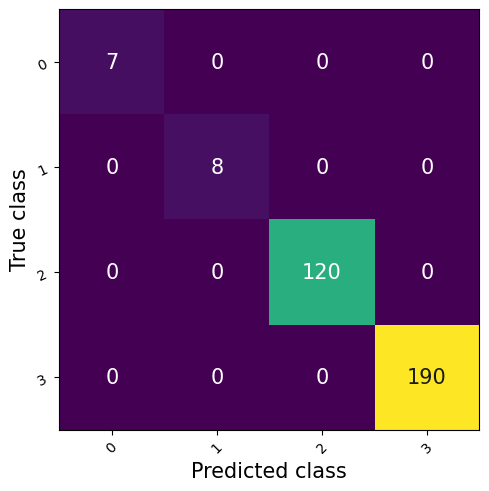

In [268]:
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_train = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_train.update(preds_train, target_train)
fig_, ax_ = metric_train.plot()

In [269]:
metric_collection(preds_train, target_train)

{'MulticlassPrecision': tensor([1., 1., 1., 1.], device='cuda:0'),
 'MulticlassRecall': tensor([1., 1., 1., 1.], device='cuda:0'),
 'MulticlassF1Score': tensor([1., 1., 1., 1.], device='cuda:0')}

### 4-2. Evaluating model with Test Dataset

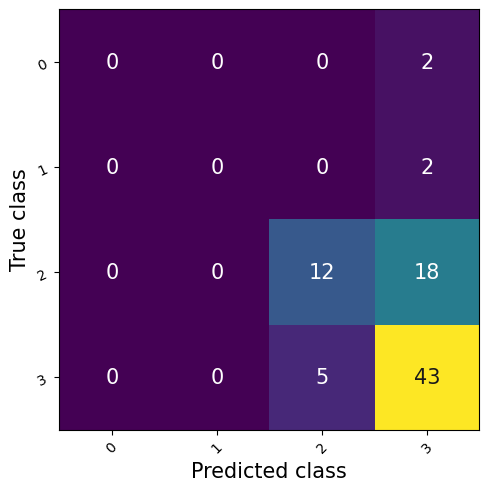

In [466]:
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_test = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_test.update(preds_test, target_test)
fig_, ax_ = metric_test.plot()

In [465]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.7059, 0.6615], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.4000, 0.8958], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.5106, 0.7611], device='cuda:0')}

## 5. Save model

In [63]:
file_name = "./Model_save/feature3201157_Adam00001s99_ep30_D8_F0_dr1.pt"
T.save(net.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved


In [47]:
# load saved model
net = Transformer_Classifier().to(device)
net.load_state_dict(T.load('./Model_save/feature3201157_Adam00001s99_ep30_D8_F0_dr1.pt'))

<All keys matched successfully>

## 6. Visualize the latent space of networks using UMAP

In [13]:
X_Train, X_Train.shape

(array([[206.81746899, 172.09803197, 195.58499015, ...,   0.        ,
         148.0143489 ,   0.        ],
        [192.49203866, 124.22168367, 183.73903337, ...,   0.        ,
         135.35931518,  90.02817139],
        [202.60430677, 174.38158934, 199.61163048, ...,   0.        ,
         168.82660949,   0.        ],
        ...,
        [215.29792955, 228.0196805 , 199.5163015 , ...,   0.        ,
         180.11650115,   0.        ],
        [218.60653373, 172.65345385, 200.12557454, ...,   0.        ,
         154.28226511,   0.        ],
        [218.31624895, 201.55425252, 201.41421976, ..., 152.7178798 ,
         158.90713207,  95.64942398]]),
 (325, 1157))

### 6-1. Analyzing Training dataset

In [14]:
mapper = umap.UMAP().fit(X_Train)

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

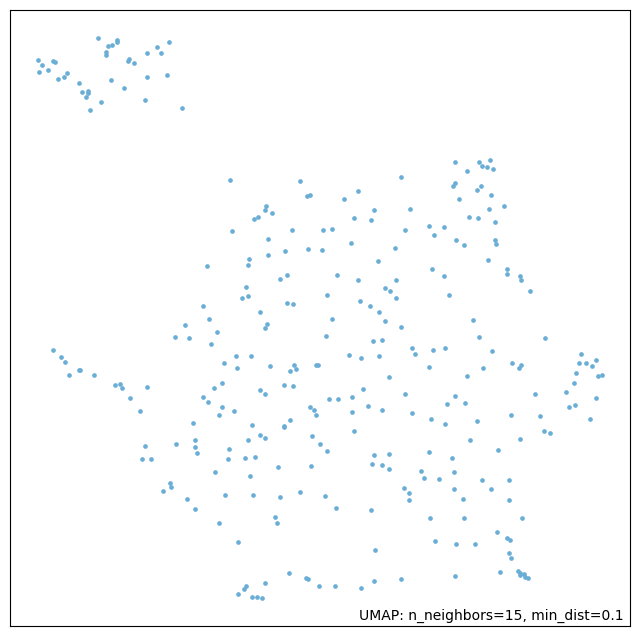

In [15]:
umap.plot.points(mapper)

In [16]:
Y_Train, Y_Train.shape

(array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

<Axes: >

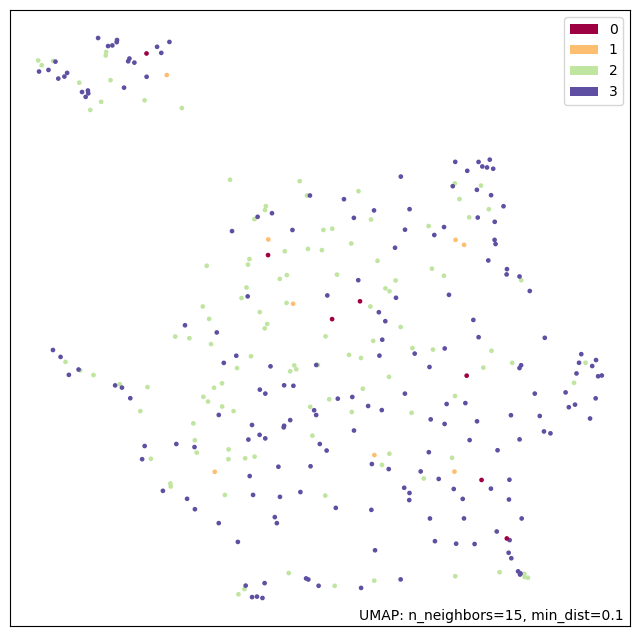

In [17]:
umap.plot.points(mapper, labels=Y_Train)#, theme='darkgreen')
# umap.plot.points(mapper, labels=Y_Train, color_key_cmap='Paired', background='black')

In [18]:
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)
umap.plot.output_notebook()

Loading BokehJS ...

In [19]:
p = umap.plot.interactive(mapper, labels=Y_Train, hover_data=hover_data, point_size=3)
umap.plot.show(p)

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/datashader/transfer_functions/__init__.py:326: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

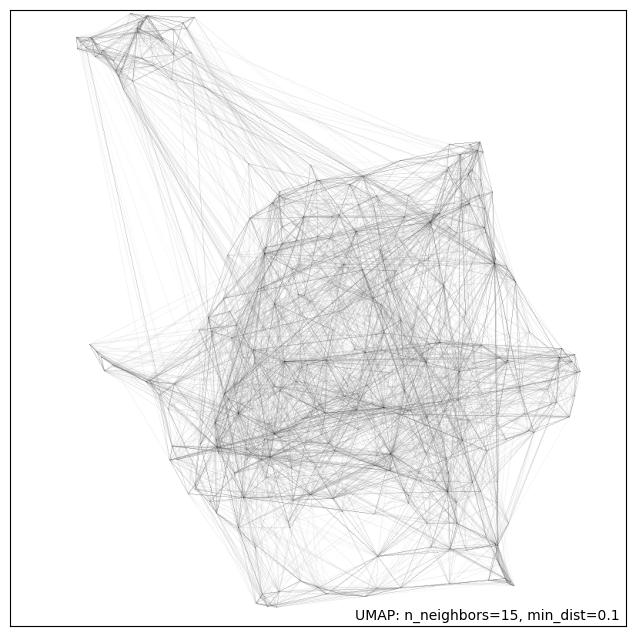

In [20]:
umap.plot.connectivity(mapper, show_points=True)

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

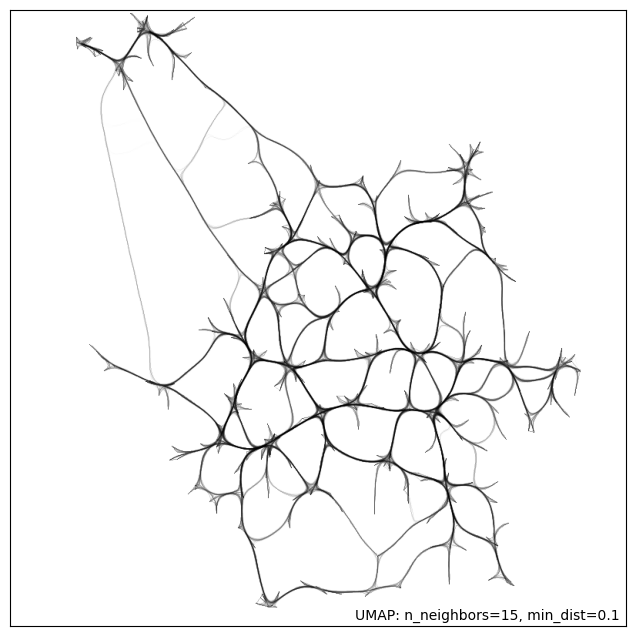

In [21]:
umap.plot.connectivity(mapper, edge_bundling='hammer')

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

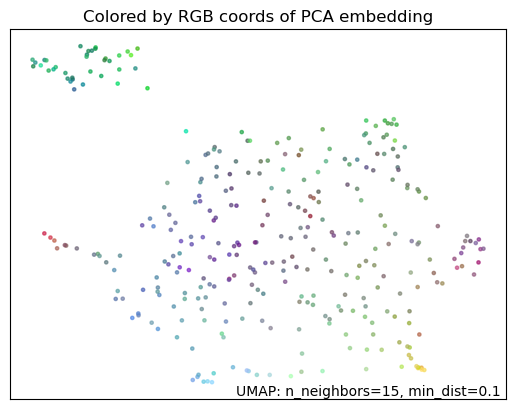

In [22]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

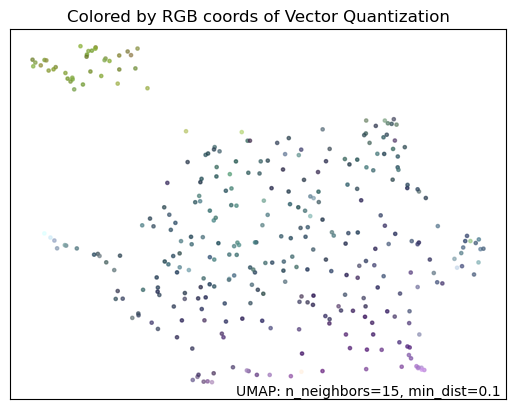

In [23]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

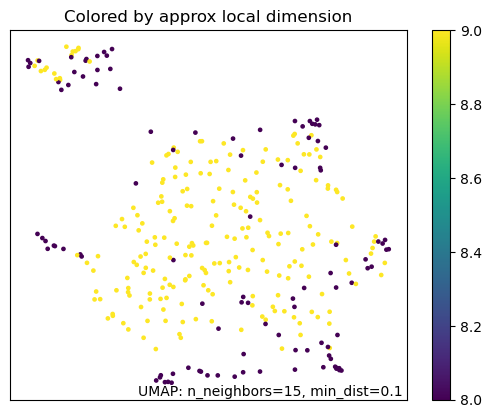

In [24]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')
# umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

### 6-2. Compute output of layers of network

In [11]:
# import gc
# net.cpu()
# del net 
# net2.cpu()
# del net2
# gc.collect()
# T.cuda.empty_cache()

In [25]:
net = Transformer_Classifier().to(device)
net.eval()
# load saved model
net2 = Transformer_Classifier().to(device2)
net2.load_state_dict(T.load('./Model_save/feature3201157_Adam00001s99_ep25_D64_F64_dr1.pt'))               
net2.eval()

Transformer_Classifier(
  (embed): Embedding(1157, 64)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_featur

In [45]:
# 훈련 안 된 모델에 train 데이터 넣어서 forward 
embedded = net.embed(train_ds.x_data)  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc1_output = T.tanh(net.fc1(z))
embedded.shape, t_encoded.shape, fc1_output.shape

(torch.Size([325, 1157, 64]),
 torch.Size([325, 1157, 64]),
 torch.Size([325, 64]))

In [46]:
# 훈련 된 모델에 train 데이터 넣어서 forward 
embedded2 = net2.embed(train_ds2.x_data)  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc1_output2 = T.tanh(net2.fc1(z))
embedded2.shape, t_encoded2.shape, fc1_output2.shape

(torch.Size([325, 1157, 64]),
 torch.Size([325, 1157, 64]),
 torch.Size([325, 64]))

In [47]:
n_sample = 325
embedded_before = embedded.detach().cpu().numpy().reshape(n_sample, -1)
embedded_after = embedded2.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_before = t_encoded.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_after = t_encoded2.detach().cpu().numpy().reshape(n_sample, -1)
fc1_output_before = fc1_output.detach().cpu().numpy()
fc1_output_after = fc1_output2.detach().cpu().numpy()
embedded_after.shape, t_encoded_after.shape, fc1_output_after.shape

((325, 74048), (325, 74048), (325, 64))

In [36]:
# 훈련 안 된 모델에 test 데이터 넣어서 forward 
embedded = net.embed(test_ds.x_data)  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc1_output = T.tanh(net.fc1(z))
embedded.shape, t_encoded.shape, fc1_output.shape

(torch.Size([82, 1157, 64]), torch.Size([82, 1157, 64]), torch.Size([82, 64]))

In [37]:
# 훈련 된 모델에 test 데이터 넣어서 forward 
embedded2 = net2.embed(test_ds2.x_data)  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc1_output2 = T.tanh(net2.fc1(z))
embedded2.shape, t_encoded2.shape, fc1_output2.shape

(torch.Size([82, 1157, 64]), torch.Size([82, 1157, 64]), torch.Size([82, 64]))

In [38]:
n_sample = 82
embedded_before = embedded.detach().cpu().numpy().reshape(n_sample, -1)
embedded_after = embedded2.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_before = t_encoded.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_after = t_encoded2.detach().cpu().numpy().reshape(n_sample, -1)
fc1_output_before = fc1_output.detach().cpu().numpy()
fc1_output_after = fc1_output2.detach().cpu().numpy()
embedded_after.shape, t_encoded_after.shape, fc1_output_after.shape

((82, 74048), (82, 74048), (82, 64))

### 6-3. Visualizing network

In [48]:
embedded_mapper_before = umap.UMAP().fit(embedded_before)
embedded_mapper_after = umap.UMAP().fit(embedded_after)

Uembedding_embedded_before = embedded_mapper_before.transform(embedded_before)
Uembedding_embedded_after = embedded_mapper_after.transform(embedded_after)

In [49]:
t_encoded_mapper_before = umap.UMAP().fit(t_encoded_before)
t_encoded_mapper_after = umap.UMAP().fit(t_encoded_after)

Uembedding_t_encoded_before = t_encoded_mapper_before.transform(t_encoded_before)
Uembedding_t_encoded_after = t_encoded_mapper_after.transform(t_encoded_after)

In [50]:
fc1_output_mapper_before = umap.UMAP().fit(fc1_output_before)
fc1_output_mapper_after = umap.UMAP().fit(fc1_output_after)

Uembedding_fc1_output_before = fc1_output_mapper_before.transform(fc1_output_before)
Uembedding_fc1_output_after = fc1_output_mapper_after.transform(fc1_output_after)

#### 6-3-1. Embdding layer before & after training

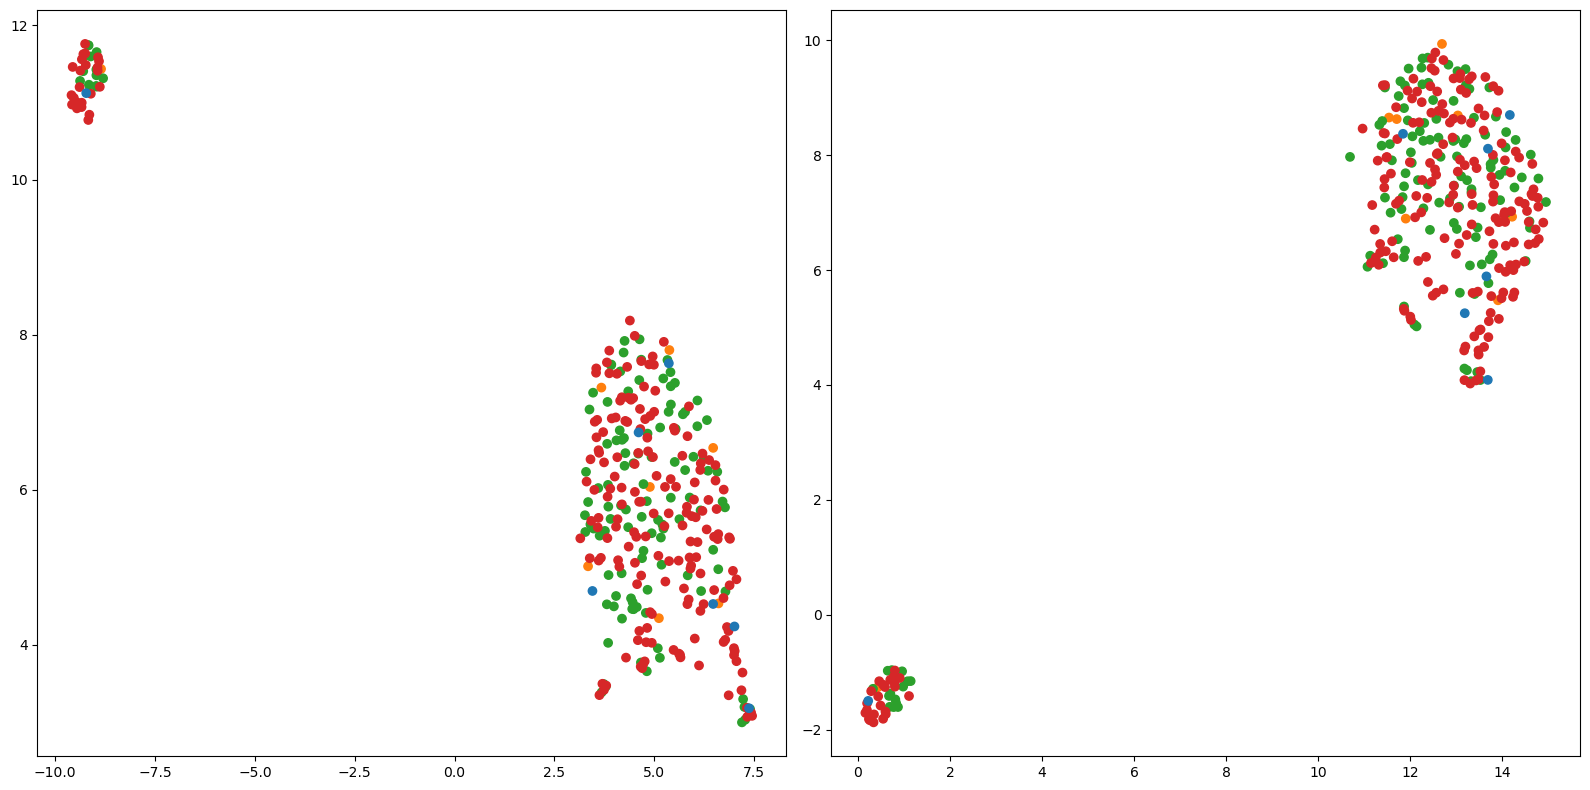

In [32]:
# Train set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

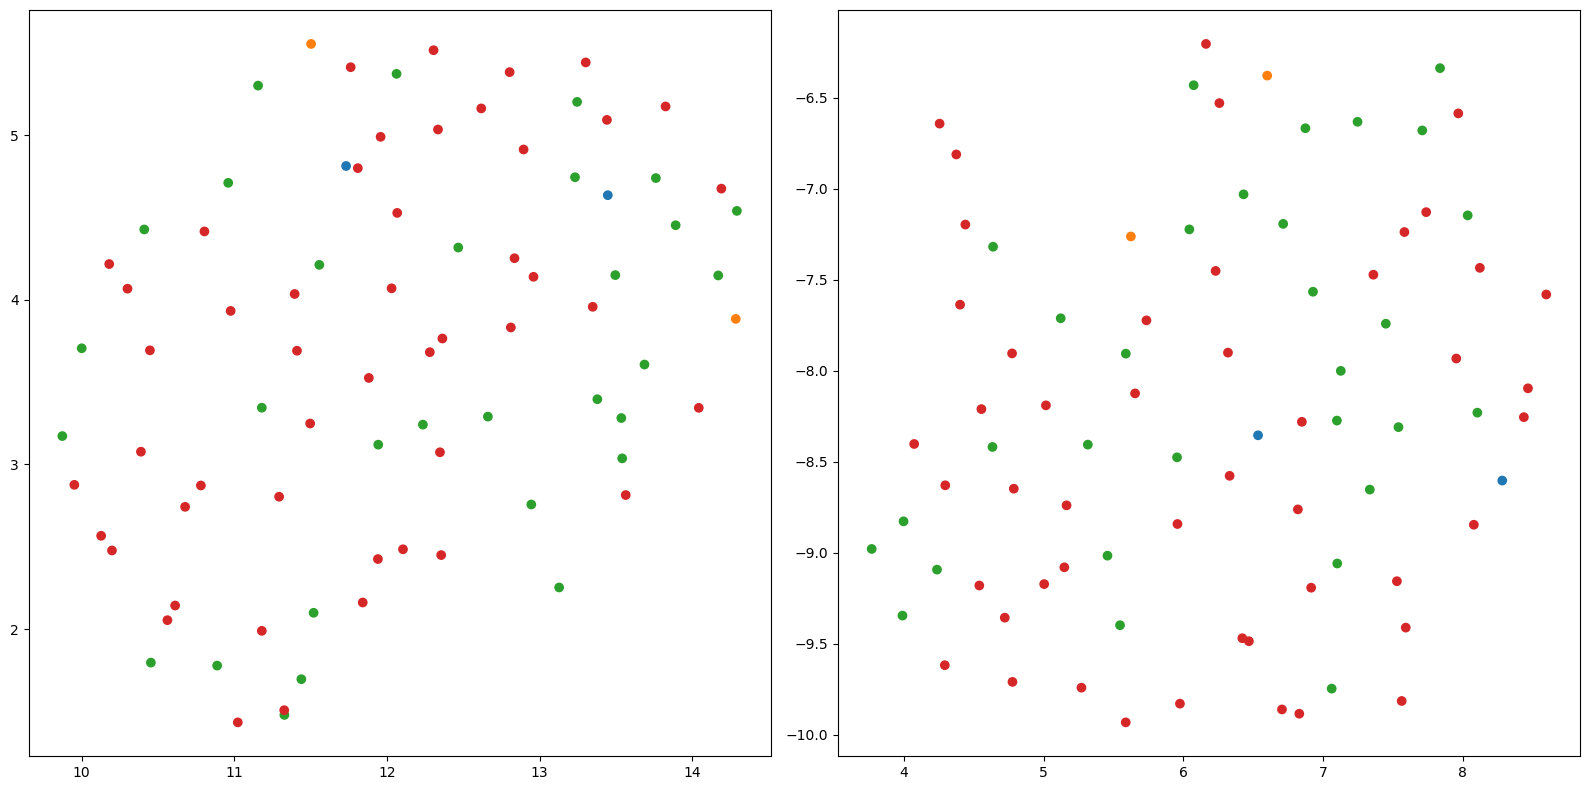

In [42]:
# Test set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-2. Transformer Encoder before & after training

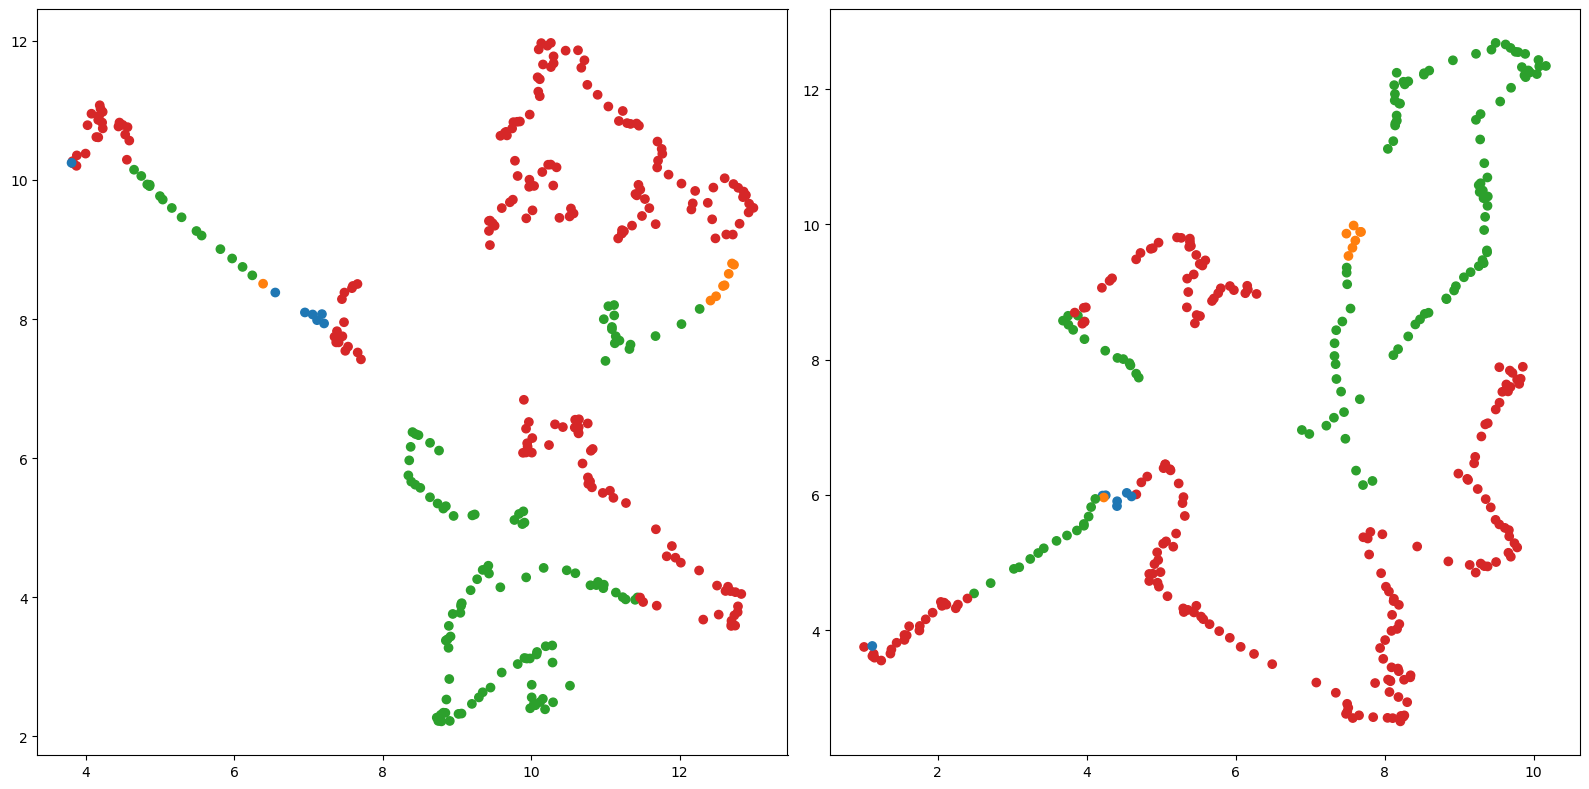

In [33]:
# Train Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

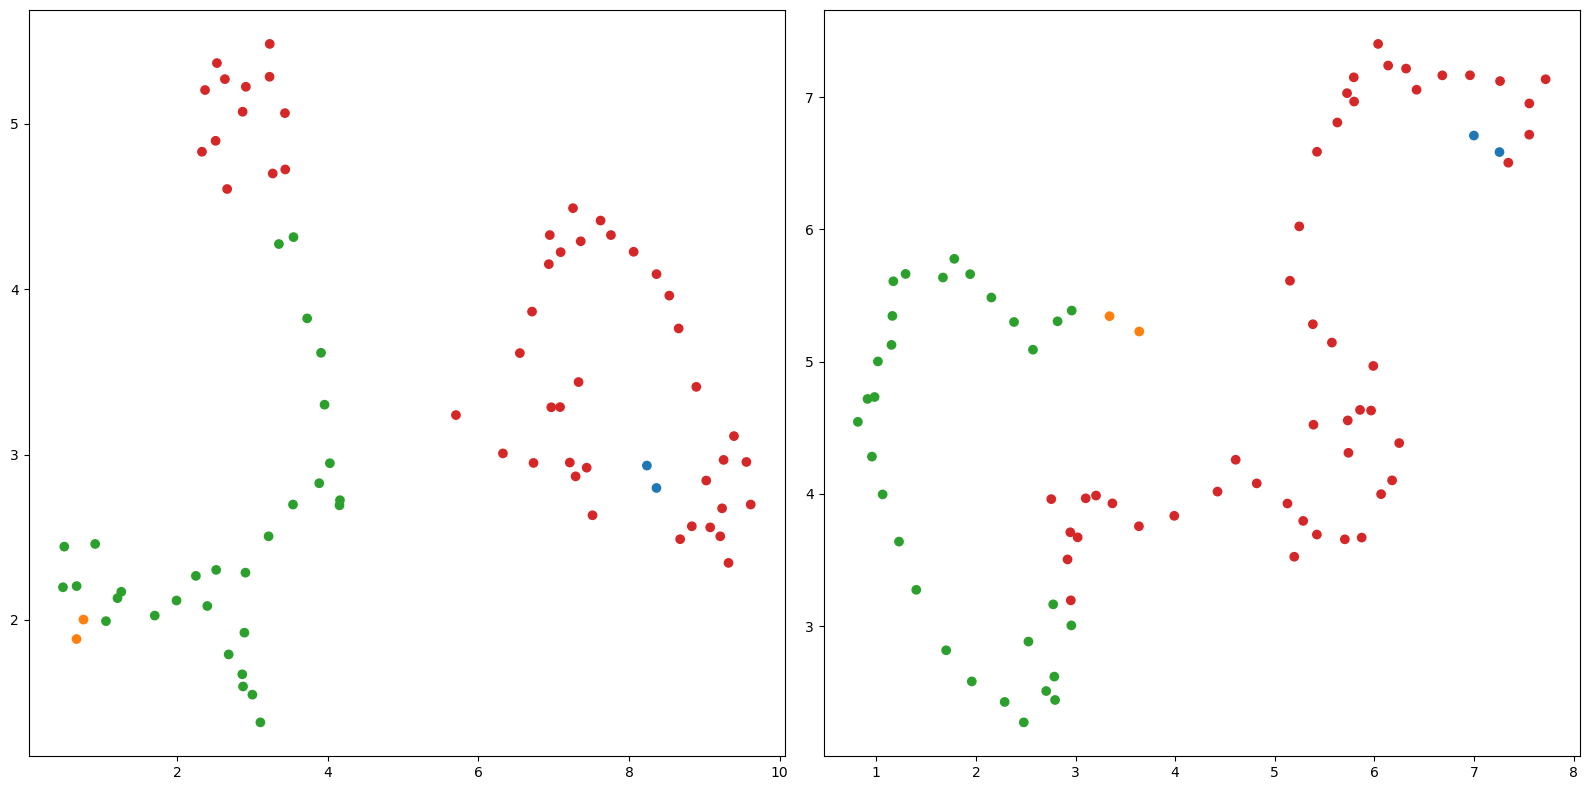

In [43]:
# Test Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-3. Fully-Connected Layer1 before & after training

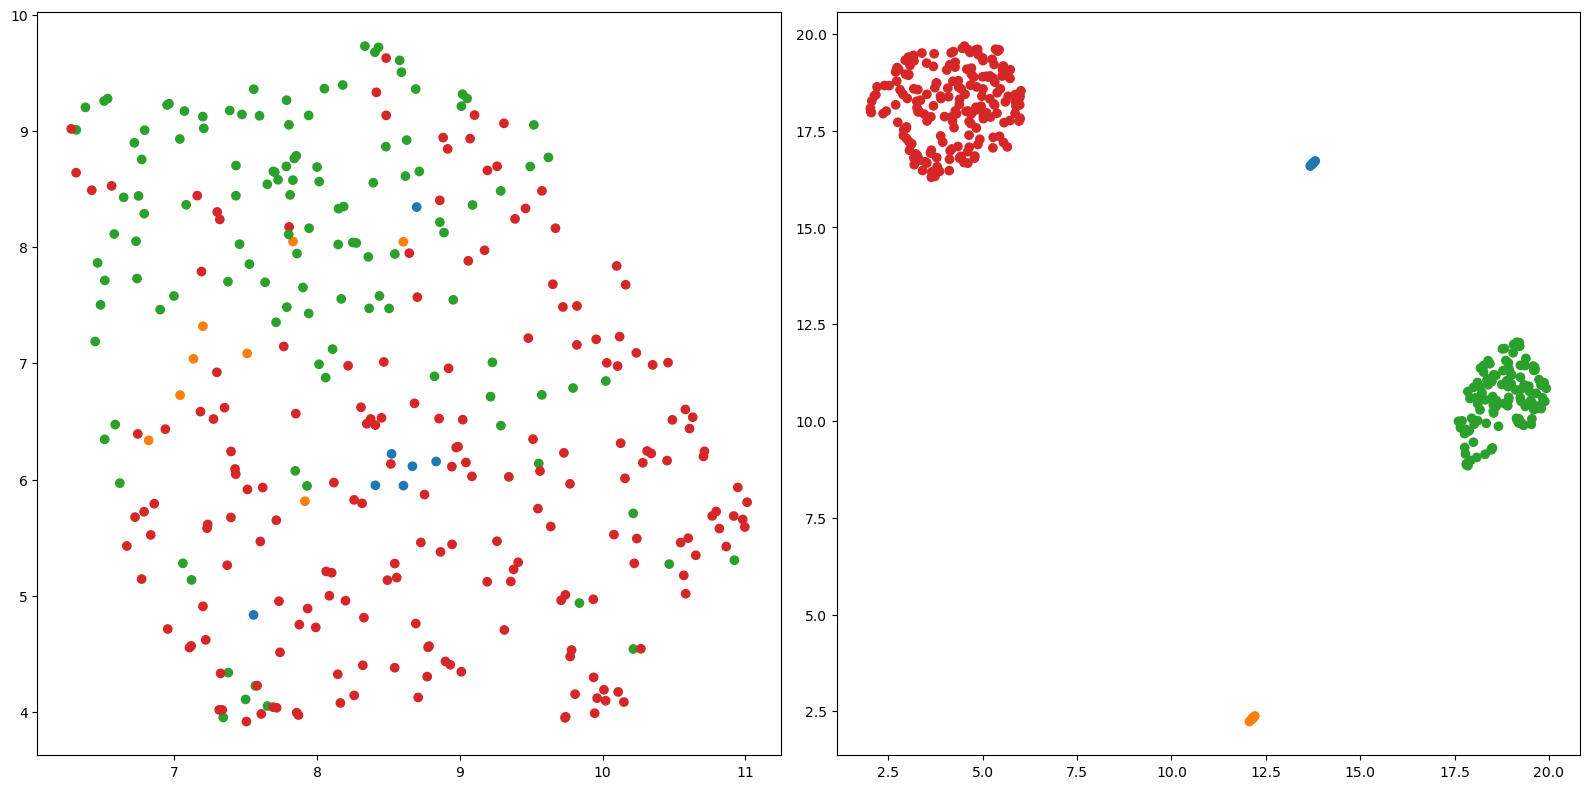

In [35]:
# Train Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc1_output_before[:, 0], Uembedding_fc1_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_fc1_output_after[:, 0], Uembedding_fc1_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

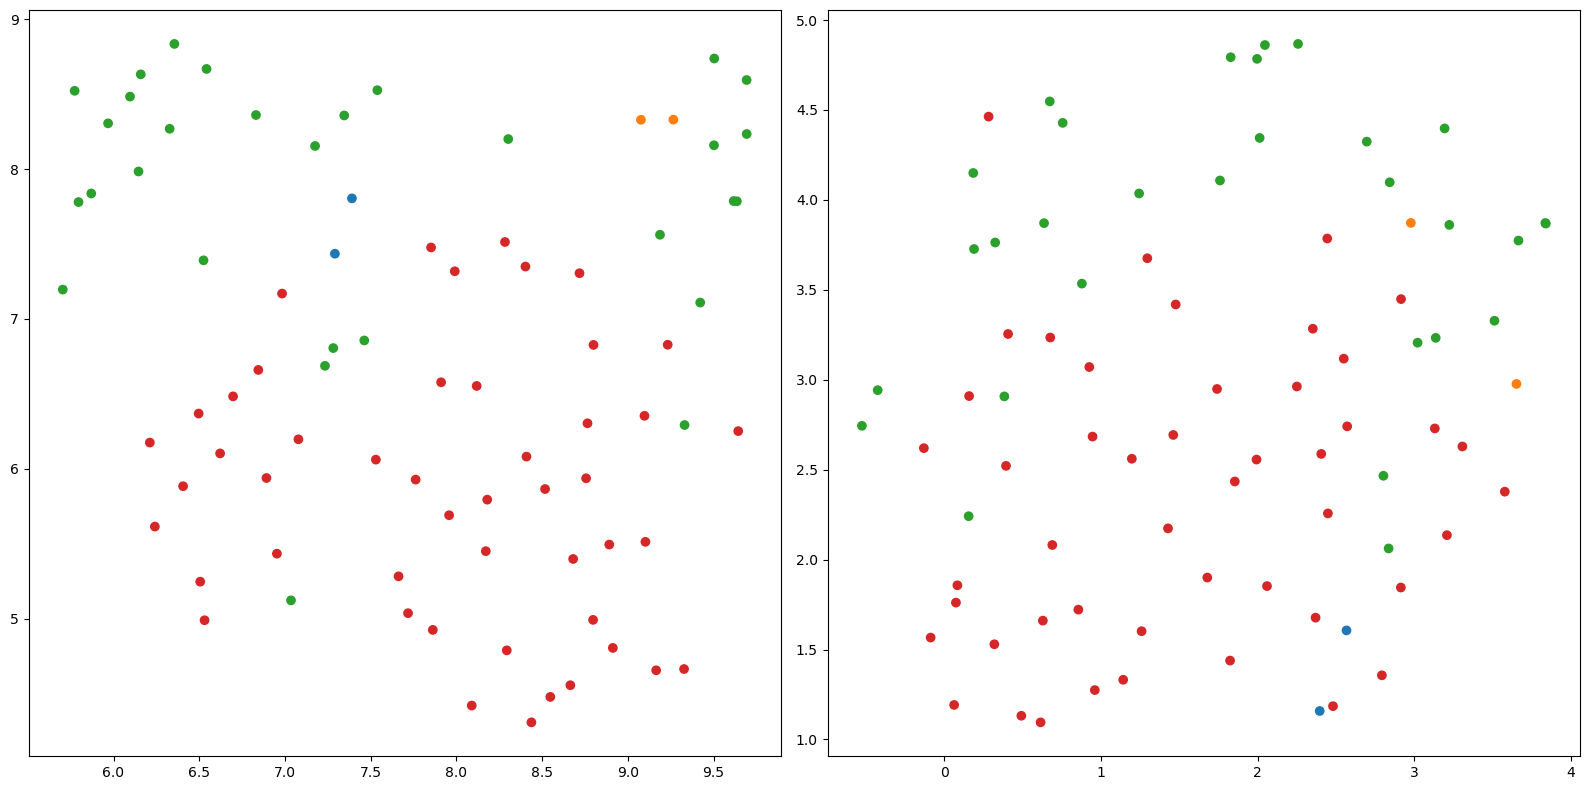

In [44]:
# Test Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc1_output_before[:, 0], Uembedding_fc1_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_fc1_output_after[:, 0], Uembedding_fc1_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

In [51]:
# FC2 Layer 들어가기 전의 데이터에서 세부사항 확인해 보기 
# (index가 나오므로 이것으로 어느 유전자인지 역추적 가능할 것임)
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)
umap.plot.output_notebook()
p = umap.plot.interactive(fc1_output_mapper_after, labels=Y_Train, hover_data=hover_data, point_size=4)
umap.plot.show(p)

## 7. Analizing the degree of contribution of each feature using SHAP

In [64]:
# model = DataParallelModel(Transformer_Classifier()).to(device)
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./Model_save/feature3201157_Adam00001s99_ep30_D8_F0_dr1.pt'))
model.eval()

Transformer_Classifier(
  (embed): Embedding(320, 8)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_fe

In [98]:
model.eval()
with T.no_grad():
    output_train = model(train_ds.x_data)
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

{'MulticlassPrecision': tensor(1., device='cuda:0'),
 'MulticlassRecall': tensor(1., device='cuda:0'),
 'MulticlassF1Score': tensor(1., device='cuda:0')}

In [74]:
def MinMax(X):
    X_norm = (X-np.min(X)) / (np.max(X)-np.min(X))
    return X_norm

In [6]:
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X, dtype=T.int32).to(device)
        outputs = model(input_tensor).detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [6]:
# dataparallelmodel 용
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X, dtype=T.int32).to(device)
        outputs = model(input_tensor)
        if len(outputs) > 1 :
            outputs1 = outputs[0].detach().cpu().numpy()
            outputs2 = outputs[1].detach().cpu().numpy()
            outputs = np.concatenate((outputs1, outputs2))
        else :
            outputs = outputs[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [7]:
# 값이 높은 데이터를 도드라지게 하지 않는 순수버전
# X_train -> model output 
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X, dtype=T.int32).to(device)
        outputs = model(input_tensor).detach().cpu().numpy()
    return outputs

In [160]:
# 값이 높은 데이터를 도드라지게 하지 않는 순수버전의 업글판 
# X_train -> model output 
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X*319, dtype=T.int64).to(device)
        outputs = model(input_tensor).detach().cpu().numpy()
    return outputs

In [6]:
# 순수버전의 DataParallelModel용
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X, dtype=T.int32).to(device)
        outputs = model(input_tensor)
        if len(outputs) > 1 :
            outputs1 = outputs[0].detach().cpu().numpy()
            outputs2 = outputs[1].detach().cpu().numpy()
            outputs = np.concatenate((outputs1, outputs2))
        else :
            outputs = outputs[0].detach().cpu().numpy()
    return outputs

In [67]:
# X_train -> trans_enc 
# 인코더 결과물 중 몇 번째 차원을 볼 것인가 임베딩 디멘션 D 중에 고를 수 있다
T_D = 0
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X, dtype=T.int32).to(device)
        z = model.embed(input_tensor)  
        z = z.reshape(-1, I, D) 
        z = model.pos_enc(z) 
        z = model.trans_enc(z) 
        outputs = z.detach().cpu().numpy()
    return outputs[:,:,T_D]

In [161]:
# X_train -> trans_enc 업글판
# 인코더 결과물 중 몇 번째 차원을 볼 것인가 임베딩 디멘션 D 중에 고를 수 있다
T_D = 0
def f(X):
    with T.no_grad():
        input_tensor = T.tensor(X*319, dtype=T.int64).to(device)
        z = net.embed(input_tensor)  
        z = z.reshape(-1, I, D) 
        z = net.pos_enc(z) 
        z = net.trans_enc(z) 
        outputs = z.detach().cpu().numpy()
    return outputs[:,:,T_D]

In [114]:
input_tensor = T.tensor(X_Train, dtype=T.int32).to(device)
z = model.embed(input_tensor)  
z = z.reshape(-1, I, D) 
z = model.pos_enc(z) 
z = model.trans_enc(z) 
outputs = z.detach().cpu().numpy()
outputs.shape

(325, 1157, 8)

#### shap.Explainer(인자1, 인자2) : 인자1 function - input (#sample * #feature), output (#sample * #class) 인자2 numpy array

#### Explainer e를 만들고 나서 e.shap_value를 만들려고 시도하면 GPU를 2배로 많이 잡아먹을 뿐만 아니라 결과값이 그냥 array로 나와서 그 후에 그래프를 그리는데 문제가 있다. 
#### 그냥 explanation = e(X_Train[:1]) 로 하게 되면 explanation이 SHAP에서 원하는 object 데이터로 뽑아지고 그 후 그래프도 쉽게 그릴 수 있다

#### f를 크게 두 가지로 해 볼 수 있다 
1. X_Train (bs, 1157) -> log_softmax(bs, 1157, 4)
2. X_Train (bs, 1157) -> X_trans_enc(bs, 1157, D)[:, :, d] 

In [91]:
np.set_printoptions(threshold=np.inf, linewidth=90)

In [93]:
np.set_printoptions(threshold=1000, linewidth=90)

In [182]:
np.seterr(divide='warn', invalid='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [163]:
X_Train, X_Train.dtype

(array([[206, 172, 195, ...,   0, 148,   0],
        [192, 124, 183, ...,   0, 135,  90],
        [202, 174, 199, ...,   0, 168,   0],
        ...,
        [215, 228, 199, ...,   0, 180,   0],
        [218, 172, 200, ...,   0, 154,   0],
        [218, 201, 201, ..., 152, 158,  95]]),
 dtype('int64'))

In [164]:
X_Train_for_SHAP, X_Train_for_SHAP.dtype

(array([[206.81746899, 172.09803197, 195.58499015, ...,   0.        ,
         148.0143489 ,   0.        ],
        [192.49203866, 124.22168367, 183.73903337, ...,   0.        ,
         135.35931518,  90.02817139],
        [202.60430677, 174.38158934, 199.61163048, ...,   0.        ,
         168.82660949,   0.        ],
        ...,
        [215.29792955, 228.0196805 , 199.5163015 , ...,   0.        ,
         180.11650115,   0.        ],
        [218.60653373, 172.65345385, 200.12557454, ...,   0.        ,
         154.28226511,   0.        ],
        [218.31624895, 201.55425252, 201.41421976, ..., 152.7178798 ,
         158.90713207,  95.64942398]]),
 dtype('<f8'))

In [165]:
X_Train_SHAP_zero_replaced, X_Train_SHAP_zero_replaced.dtype

(array([[2.06817469e+02, 1.72098032e+02, 1.95584990e+02, ...,
         1.03400000e-01, 1.48014349e+02, 1.03450000e-01],
        [1.92492039e+02, 1.24221684e+02, 1.83739033e+02, ...,
         1.05850000e-01, 1.35359315e+02, 9.00281714e+01],
        [2.02604307e+02, 1.74381589e+02, 1.99611630e+02, ...,
         1.08150000e-01, 1.68826609e+02, 1.08200000e-01],
        ...,
        [2.15297930e+02, 2.28019680e+02, 1.99516302e+02, ...,
         9.56200000e-01, 1.80116501e+02, 9.56250000e-01],
        [2.18606534e+02, 1.72653454e+02, 2.00125575e+02, ...,
         9.59200000e-01, 1.54282265e+02, 9.59250000e-01],
        [2.18316249e+02, 2.01554253e+02, 2.01414220e+02, ...,
         1.52717880e+02, 1.58907132e+02, 9.56494240e+01]]),
 dtype('float64'))

### 7-1. SampleExplainer

In [212]:
se = shap.SamplingExplainer(f, MinMax(X_Train_SHAP_zero_replaced)[0:325])
explanation = se(MinMax(X_Train_SHAP_zero_replaced)[0:1])
explanation, explanation.shape

  0%|          | 0/1 [00:00<?, ?it/s]

Mean of empty slice.
invalid value encountered in divide
Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in cast
overflow encountered in scalar multiply
invalid value encountered in sqrt


(.values =
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]])
 
 .base_values =
 array([-0.28604739, -0.2567277 , -0.32063428, ..., -0.37741266,
        -0.26363105, -0.20041568])
 
 .data =
 array([[6.48220348e-01, 5.39347858e-01, 6.12997774e-01, ...,
         1.06616494e-05, 4.63826745e-01, 1.08184384e-05]]),
 (1, 1157, 1157))

TypeError: 'numpy.float64' object is not iterable

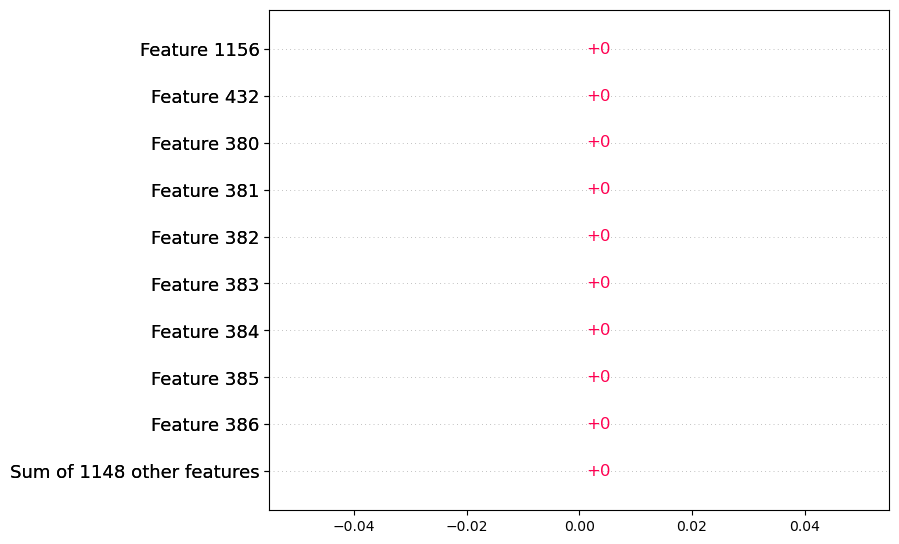

In [113]:
shap.plots.bar(explanation[0])